In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


spark = SparkSession.builder.appName('Spark_ML').getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [2]:
df = sqlContext.read.parquet('/home/youssouf/Documents/code/diakite-data/kikckstarter/data/kickstarter.parquet-20200305T090901Z-001/kickstarter.parquet')

In [3]:
df.printSchema()

root
 |-- project_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- goal: double (nullable = true)
 |-- keywords: string (nullable = true)
 |-- final_status: integer (nullable = true)
 |-- country_clean: string (nullable = true)
 |-- currency_clean: string (nullable = true)
 |-- deadline_clean: date (nullable = true)
 |-- created_at_clean: date (nullable = true)
 |-- launched_at_clean: date (nullable = true)
 |-- days_campaign: integer (nullable = true)
 |-- hours_prepa: double (nullable = true)



In [37]:
df.toPandas().head(5)

,project_id,name,desc,goal,keywords,final_status,country_clean,currency_clean,deadline_clean,created_at_clean,launched_at_clean,days_campaign,hours_prepa
0,kkst2105441663,turn my paintings into prints!,i am looking to get prints made of my painting...,750.0,turn-my-paintings-into-prints,0,US,USD,2010-07-31,2010-06-14,2010-06-16,45,29.69
1,kkst1445351354,living with models,lauren won her own reality show! too bad this ...,2500.0,living-with-models,1,US,USD,2011-09-07,2011-08-06,2011-08-08,30,62.02
2,kkst1900926901,enchiridion,a priest is enlisted by federal marshals to as...,2500.0,enchiridion,0,US,USD,2011-09-29,2011-08-24,2011-08-30,30,143.80
3,kkst473899686,on paper and with strangers: part two (canceled),a book comprised of photographs and writing. a...,1869.0,on-paper-and-with-strangers-part-two,0,US,USD,2011-05-01,2011-03-22,2011-03-22,40,1.99
4,kkst1247306035,my memphis blues,my memphis blues is a collection of poetry fro...,5000.0,my-memphis-blues,0,US,USD,2011-05-10,2011-02-02,2011-02-08,91,134.81


In [6]:
df2 = df.select('goal', 'country_clean', 'currency_clean', 'days_campaign', 'hours_prepa', 'final_status')

In [7]:
df2.show(5)

+------+-------------+--------------+-------------+-----------+------------+
|  goal|country_clean|currency_clean|days_campaign|hours_prepa|final_status|
+------+-------------+--------------+-------------+-----------+------------+
| 750.0|           US|           USD|           45|      29.69|           0|
|2500.0|           US|           USD|           30|      62.02|           1|
|2500.0|           US|           USD|           30|      143.8|           0|
|1869.0|           US|           USD|           40|       1.99|           0|
|5000.0|           US|           USD|           91|     134.81|           0|
+------+-------------+--------------+-------------+-----------+------------+
only showing top 5 rows



### Dimensions of dataset 

In [8]:
(df2.count() , len(df2.columns))

(107615, 6)

### Missing Values Count

In [9]:
# import sql function pyspark
import pyspark.sql.functions as f

# null values in each column
data_agg = df2.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df2.columns])
data_agg.show()

+----+-------------+--------------+-------------+-----------+------------+
|goal|country_clean|currency_clean|days_campaign|hours_prepa|final_status|
+----+-------------+--------------+-------------+-----------+------------+
|   0|            0|             0|            0|          0|           0|
+----+-------------+--------------+-------------+-----------+------------+



In [10]:
### Value count for column final status

df2.groupBy('final_status').count().show()

+------------+-----+
|final_status|count|
+------------+-----+
|           1|34394|
|           0|73221|
+------------+-----+



107615


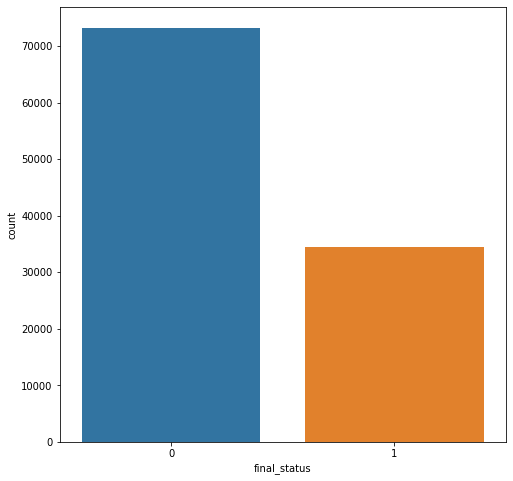

In [40]:
# let's have a look at the distribution of our target variable:
# to make it look better, we first convert our spark df to a Pandas


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = df2.toPandas()
print(len(df_pd))
plt.figure(figsize=(8,8))
sns.countplot(x='final_status', data=df_pd, order=df_pd['final_status'].value_counts().index)

Our dataset is very imbalanced. So to resolve this matter we are going to use some methode like **SMOTE** , etc..

### Deal with imbalanced classes

There are different methods to mitigate this problem. one way is to **under sample the majority class** or **over sample the minority class** to make a more balanced results. Another way is to assign weights for each class to penalize the majority class by assigning less weight and boost the minority class by assigning bigger weight. we are going to create a new column in the dataset named **weights** and assign the inverse ratio of each class as weights. here is how it’s done:

In [12]:
# adding the new column weights and fill it with ratios
from pyspark.sql.functions import when,col


ratio = 0.91
def weight_balance(final):
    return when(final == 1, ratio).otherwise(1*(1-ratio))
df3 = df2.withColumn('weights', weight_balance(col('final_status')))

In [13]:
df3.show(5)

+------+-------------+--------------+-------------+-----------+------------+-------------------+
|  goal|country_clean|currency_clean|days_campaign|hours_prepa|final_status|            weights|
+------+-------------+--------------+-------------+-----------+------------+-------------------+
| 750.0|           US|           USD|           45|      29.69|           0|0.08999999999999997|
|2500.0|           US|           USD|           30|      62.02|           1|               0.91|
|2500.0|           US|           USD|           30|      143.8|           0|0.08999999999999997|
|1869.0|           US|           USD|           40|       1.99|           0|0.08999999999999997|
|5000.0|           US|           USD|           91|     134.81|           0|0.08999999999999997|
+------+-------------+--------------+-------------+-----------+------------+-------------------+
only showing top 5 rows



### Feature Engineering

The next step is Feature Engineering. pySpark has made it so easy that we do not need to do much for extracting features. here are the steps:

*1-we apply StringIndexer() to assign indices to each category in our categorical columns.
*2-we apply OneHotEncoderEstimator() to convert categorical columns to onehot encoded vectors.
*3- we apply VectorAssembler() to create a feature vector from all categorical and numerical features and we call the final vector as "features".

In [19]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

# define stage 1: transform the column country_clean to numeric
stage_1 = StringIndexer(inputCol= 'country_clean', outputCol= 'country_clean_index')
# define stage 2: transform the column currency_clean to numeric
stage_2 = StringIndexer(inputCol= 'currency_clean', outputCol= 'currency_clean_index')
# define stage 3: one hot encode the numeric versions of country_clean and currency_clean generated from stage 1 and stage 2
stage_3 = OneHotEncoderEstimator(inputCols=[stage_1.getOutputCol(), stage_2.getOutputCol()], 
                                 outputCols= ['country_clean_encoded', 'currency_clean_encoded'])
# define stage 4: create a vector of all the features required to train the logistic regression model 
stage_4 = VectorAssembler(inputCols=['goal', 'country_clean_encoded', 'currency_clean_encoded', 'days_campaign', 'hours_prepa'],
                          outputCol='features')


In [21]:
from pyspark.ml import Pipeline
#import pandas as pd

stages = [stage_1,stage_2,stage_3,stage_4]

cols = df3.columns

pipeline = Pipeline(stages = stages)

pipelineModel = pipeline.fit(df3)

df4 = pipelineModel.transform(df3)

selectedCols = ['features'] + cols

df5 = df4.select(selectedCols)

#pd.DataFrame(df5.take(5), columns = df5.columns)


### Training and Hyper-parameter Tuning

#### Logistic Regression

In [22]:
# split the data into trainign and testin sets
train, test = df5.randomSplit([0.80, 0.20], seed = 12345)
print("number of rows of train :",train.count())
print("number of rows of test:",test.count())


# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'final_status', maxIter=15)
LR_model = LR.fit(train)

number of rows of train : 86091
number of rows of test: 21524


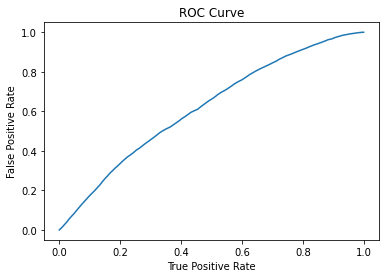

Training set ROC: 0.6189649060449569


In [36]:
#plotting the ROC Curve
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()


plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

#### Model’s performance on the testing set

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='final_status')
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6114710679650361


####  Gradient Boosting Trees (GBT)

In [35]:
# next we checkout gradient boosting trees
from pyspark.ml.classification import GBTClassifier
import mlflow.spark
import mlflow

mlflow.set_tracking_uri('http://35.246.84.226')
mlflow.set_experiment('kickstarter')

gbt = GBTClassifier(featuresCol = 'features', labelCol = 'final_status',maxIter=15)

with mlflow.start_run() as active_run :

    GBT_Model = gbt.fit(train)

    gbt_predictions = GBT_Model.transform(test)
    train_predict = GBT_Model.transform(train)
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='final_status')
    
    train_metric = evaluator.evaluate(train_predict, {evaluator.metricName: "areaUnderROC"})
    test_metric = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})
    
    metrics = {'train_auc' : train_metric, 'test_auc' : test_metric}
    mlflow.log_metrics(metrics)
    
    params = {'model_class' : 'gbt', "max_iter" : gbt.getMaxIter()}
    mlflow.log_params(params)
    
    
    #Log spark learn model
    mlflow.spark.log_model(spark_model=GBT_Model,artifact_path="my_model")
    
    print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6674468406989197


In [59]:
from pyspark.ml.classification import  RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'final_status')
# fit train data
rfModel = rf.fit(train)


with mlflow.start_run() as active_run :
    
    # Transform train and test data for predictions
    rf_test_predict = rfModel.transform(test)
    rf_train_predict = rfModel.transform(train)
    
    # set evaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='final_status')

    # metric value on train and test data 
    train_metric = evaluator.evaluate(rf_train_predict, {evaluator.metricName: "areaUnderROC"})
    test_metric = evaluator.evaluate(rf_test_predict, {evaluator.metricName: "areaUnderROC"})
    
    # set up the set of metrics 
    metrics = {'train_auc' : train_metric, 'test_auc' : test_metric}
    mlflow.log_metrics(metrics)
    
    # model param to see on mlflow
    params = {'model_class' : 'RandomForest', "depth" : rf.getMaxDepth() }
    mlflow.log_params(params)
    
    #Log spark learn model
    mlflow.spark.log_model(spark_model= rfModel,artifact_path="my_RFmodel")
    
    # Save model
    mlflow.spark.save_model(rfModel, "my_RFmodel")

In [62]:
rfmodel=mlflow.spark.load_model("my_RFmodel")

2020/03/05 21:22:28 INFO mlflow.spark: File 'my_RFmodel/sparkml' is already on DFS, copy is not necessary.


In [70]:
rfmodel.transform(df5).toPandas().head(5)

,features,goal,country_clean,currency_clean,days_campaign,hours_prepa,final_status,weights,rawPrediction,probability,prediction
0,"(750.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",750.0,US,USD,45,29.69,0,0.09,"[13.604325118182848, 6.3956748818171505]","[0.6802162559091424, 0.3197837440908575]",0.0
1,"(2500.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2500.0,US,USD,30,62.02,1,0.91,"[13.650406943165939, 6.3495930568340615]","[0.6825203471582969, 0.3174796528417031]",0.0
2,"(2500.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2500.0,US,USD,30,143.80,0,0.09,"[13.15215248526444, 6.847847514735559]","[0.657607624263222, 0.34239237573677794]",0.0
3,"(1869.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",1869.0,US,USD,40,1.99,0,0.09,"[13.650406943165939, 6.3495930568340615]","[0.6825203471582969, 0.3174796528417031]",0.0
4,"(5000.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",5000.0,US,USD,91,134.81,0,0.09,"[14.112603582211975, 5.887396417788025]","[0.7056301791105988, 0.2943698208894013]",0.0
